# Temporal Difference 

2020 Jérémie Decock

[![My Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gl/jdhp%2Fslides-rl/HEAD?filepath=labs%2Flab_rl4_policy_iteration.ipynb)

[![NbViewer](https://raw.githubusercontent.com/jupyter/design/master/logos/Badges/nbviewer_badge.svg)](https://nbviewer.jupyter.org/urls/gitlab.com/jdhp/slides-rl/-/raw/master/labs/lab_rl4_policy_iteration.ipynb/%3Finline)

[![Local](https://img.shields.io/badge/Local-Save%20As...-blue)](https://gitlab.com/jdhp/slides-rl/-/raw/master/labs/lab_rl4_policy_iteration.ipynb?inline=false)

## Introduction

The purpose of this lab is to introduce some classic concepts used
in reinforcement learning, with the *Policy Iteration* algorithm, one of the two main *Dynamic Programming* methods.
$
\newcommand{\vs}[1]{\mathbf{#1}} % vector symbol (\boldsymbol, \textbf or \vec)
\newcommand{\ms}[1]{\mathbf{#1}} % matrix symbol (\boldsymbol, \textbf)
\def\U{V}
\def\action{\vs{a}}       % action
\def\A{\mathcal{A}}        % TODO
\def\actionset{\mathcal{A}} %%%
\def\discount{\gamma}  % discount factor
\def\state{\vs{s}}         % state
\def\S{\mathcal{S}}         % TODO
\def\stateset{\mathcal{S}}  %%%
%
\def\E{\mathbb{E}}
%\newcommand{transition}{T(s,a,s')}
%\newcommand{transitionfunc}{\mathcal{T}^a_{ss'}}
\newcommand{transitionfunc}{P}
\newcommand{transitionfuncinst}{P(\nextstate|\state,\action)}
\newcommand{transitionfuncpi}{\mathcal{T}^{\pi_i(s)}_{ss'}}
\newcommand{rewardfunc}{r}
\newcommand{rewardfuncinst}{r(\state,\action,\nextstate)}
\newcommand{rewardfuncpi}{r(s,\pi_i(s),s')}
\newcommand{statespace}{\mathcal{S}}
\newcommand{statespaceterm}{\mathcal{S}^F}
\newcommand{statespacefull}{\mathcal{S^+}}
\newcommand{actionspace}{\mathcal{A}}
\newcommand{reward}{R}
\newcommand{statet}{S}
\newcommand{actiont}{A}
%\newcommand{newstatet}{S'}
\newcommand{nextstate}{\state'}
\newcommand{newactiont}{A'}
\newcommand{stepsize}{\alpha}
\newcommand{discount}{\gamma}
\newcommand{qtable}{q_*}
\newcommand{finalstate}{\state_F}
%
\newcommand{\vs}[1]{\boldsymbol{#1}} % vector symbol (\boldsymbol, \textbf or \vec)
\newcommand{\ms}[1]{\boldsymbol{#1}} % matrix symbol (\boldsymbol, \textbf)
\def\vit{Value Iteration}
\def\pit{Policy Iteration}
\def\discount{\gamma}  % discount factor
\def\state{\vs{s}}         % state
\def\S{\mathcal{S}}         % TODO
\def\stateset{\mathcal{S}}  %%%
\def\cstateset{\mathcal{X}} %%%
\def\x{\vs{x}}                    % TODO cstate
\def\cstate{\vs{x}}               %%%
\def\policy{\pi}
\def\piparam{\vs{\theta}}         % TODO pparam
\def\action{\vs{a}}       % action
\def\A{\mathcal{A}}        % TODO
\def\actionset{\mathcal{A}} %%%
\def\caction{\vs{u}}       % action
\def\cactionset{\mathcal{U}} %%%
\def\decision{\vs{d}}       % decision
\def\randvar{\vs{\omega}}       %%%
\def\randset{\Omega}       %%%
\def\transition{T}       %%%
\def\immediatereward{r}    %%%
\def\strategichorizon{s}    %%% % TODO
\def\tacticalhorizon{k}    %%%  % TODO
\def\operationalhorizon{h}    %%%
\def\constalpha{a}    %%%
\def\U{V}              % utility function
\def\valuefunc{V}
\def\X{\mathcal{X}}
\def\meu{Maximum Expected Utility}
\def\finaltime{T}
\def\timeindex{t}
\def\iterationindex{i}
\def\decisionfunc{d}       % action
\def\mdp{\text{MDP}}
$

**Notice**: Here we assume that the reward only depends on the state: $r(\state) \equiv \mathcal{R}(\state, \action, \state')$.

**Notice**: this notebook requires the OpenAI *Gym* library ; you can install it with `pip install gym` (the next cell does this for you if you use the Google Colab environment).

In [1]:
colab_requirements = [
    "matplotlib>=3.1.2",
    "numpy>=1.18.1",
    "nose>=1.3.7",
    "gym=>0.15.4",
]
import sys, subprocess
def run_subprocess_command(cmd):
    # run the command
    process = subprocess.Popen(cmd.split(), stdout=subprocess.PIPE)
    # print the output
    for line in process.stdout:
        print(line.decode().strip())
        
if "google.colab" in sys.modules:
    for i in colab_requirements:
        run_subprocess_command("pip install " + i)

You can uncomment the following cell to install gym in MyBinder or in your local environment (remove only the `#` not the `!`).

In [2]:
#!pip install gym

In [3]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

import math
import gym
import numpy as np
import copy
import pandas as pd
import seaborn as sns

In [4]:
sns.set_context("talk")

In [5]:
#matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)

## Setup the FrozenLake toy problem with OpenAI Gym

For the purpose of focusing on the algorithms, we will use standard environments provided by OpenAI Gym framework.
OpenAI Gym provides controllable environments (https://gym.openai.com/envs/) for research in Reinforcement Learning.
We will use a simple toy problem to illustrate Dynamic Programming algorithms properties.

In this lab, we will try to solve the FrozenLake-v0 environment (https://gym.openai.com/envs/FrozenLake-v0/).
Additional information is available [here](https://github.com/openai/gym/wiki/FrozenLake-v0) and [here](https://github.com/openai/gym/wiki/FrozenLake-v0).

**Notice**: this environment is *fully observable*, thus here the terms (environment) *state* and (agent) *observation* are equivalent.
This is not always the case for example in poker, the agent doesn't know the opponent's cards.

### Get the FrozenLake state space and action space

In [6]:
env = gym.make('FrozenLake-v0')

Possible states in FrozenLake are:

In [7]:
states = list(range(env.observation_space.n))
states

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

Possible actions are:

In [8]:
actions = list(range(env.action_space.n))
actions

[0, 1, 2, 3]

The following dictionary may be used to understand actions:

In [9]:
action_labels = {
    0: "Move Left",
    1: "Move Down",
    2: "Move Right",
    3: "Move Up"
}

### Display functions

The next cells contain functions that can be used to display states, transitions and policies with the FrozenLake environment.

In [10]:
def states_display(state_seq, title=None, figsize=(5,5), annot=True, fmt="0.1f", linewidths=.5, square=True, cbar=False, cmap="Reds"):
    size = int(math.sqrt(len(state_seq)))
    state_array = np.array(state_seq)
    state_array = state_array.reshape(size, size)
    
    fig, ax = plt.subplots(figsize=figsize)         # Sample figsize in inches
    sns.heatmap(state_array, annot=annot, fmt=fmt, linewidths=linewidths, square=square, cbar=cbar, cmap=cmap)
    plt.title(title)
    plt.show()

In [11]:
def transition_display(state, action):
    states_display(transition_array[state,action], title="Transition probabilities for action {} ({}) in state {}".format(action, action_labels[action], state))

In [12]:
def display_policy(policy):
    actions_src = ["{}={}".format(action, action_labels[action].replace("Move ", "")) for action in actions]
    title = "Policy (" + ", ".join(actions_src) + ")"
    states_display(policy, title=title, fmt="d", cbar=False, cmap="Reds")

### Make the `is_final_array`, `reward_array` and `transition_array`

To implement Dynamic Programming algorithms, we need the transition probability (or transition function) and the reward function, both defined in `env.P`.

`env.P[S][A]` gives the list of reachable states from state S executing action A.

These reachable states are coded in a tuple defined like this: `(probability, next state, reward, is_final_state)`.

You will not need to use `env.P` to solve exercises.
In the following cell, `is_final_array`, `reward_array` and `transition_array` are defined for convenience.

In [50]:
is_final_array = np.full(shape=len(states), fill_value=np.nan, dtype=np.bool)
reward_array = np.full(shape=len(states), fill_value=np.NINF)                # np.NINF = negative infinity
transition_array = np.zeros(shape=(len(states), len(actions), len(states)))

for state in states:
    for action in actions:
        for next_state_tuple in env.P[state][action]:              # env.P[state][action] contains the next states list (a list of tuples)
            transition_probability, next_state, next_state_reward, next_state_is_final = next_state_tuple

            is_final_array[next_state] = next_state_is_final
            reward_array[next_state] = max(reward_array[next_state], next_state_reward)   # workaround: when we already are in state 15, reward is 0 if we stay in state 15 (in practice this never append as the simulation stop when we arrive in state 15 as any other terminal state)
            transition_array[state, action, next_state] += transition_probability

In [13]:
def reachable_states(state, action):
    return np.nonzero(transition_array[state, action])[0]

The following plot shows the state corresponding to square of the FrozenLake grid.

## Exercise: Implement the Temporal Difference algorithm

In [26]:
value_function_history = []
alpha_history = []

def TemporalDiff(policy, NUM_EPISODES=1000, alpha=0.5, alpha_factor=0.995, gamma=0.95):
    
    V_array = np.zeros(np.array(states).shape)
    
    for episode_index in range(NUM_EPISODES):
        value_function_history.append(V_array.copy())
        alpha_history.append(alpha)
        
        state = env.reset()
        done = False

        alpha = alpha * alpha_factor
        
        while not done:
            action = policy[state]      
            state_new, reward, done, info = env.step(action)
            V_array[state] = V_array[state] + alpha * (reward + gamma * V_array[state_new] - V_array[state])
            state = state_new
            

    env.close()
    return V_array

In [27]:
policy = [0, 3, 0, 3, 0, 0, 2, 1, 3, 1, 0, 0, 0, 2, 1, 0]

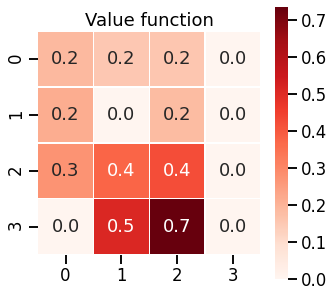

In [28]:
v1 = TemporalDiff(policy)
states_display(v1, title="Value function", cbar=True, cmap="Reds")

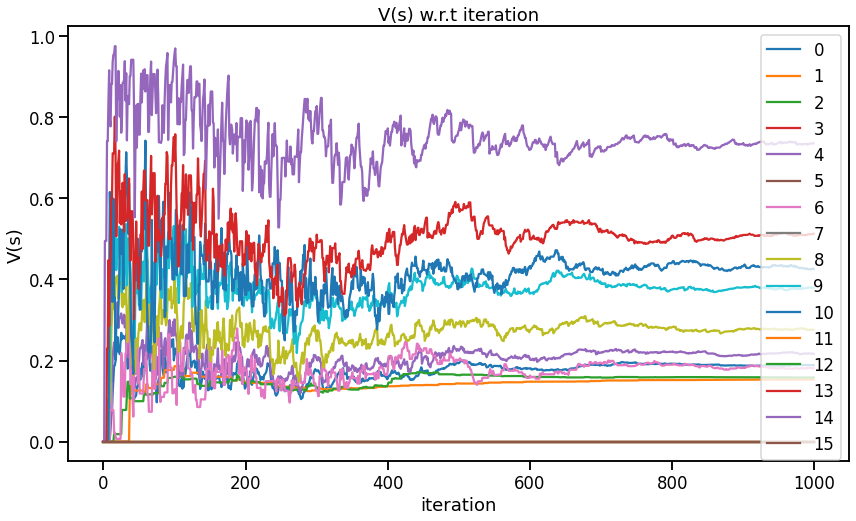

In [29]:
df_v_hist = pd.DataFrame(value_function_history)
df_v_hist.plot(figsize=(14,8))
plt.title("V(s) w.r.t iteration")
plt.ylabel("V(s)")
plt.xlabel("iteration")
plt.legend(loc='upper right');

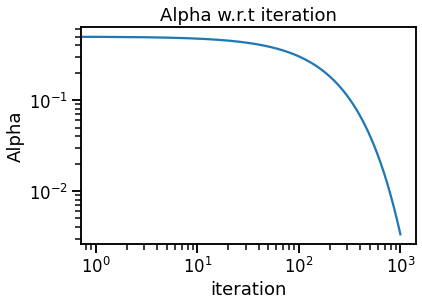

In [30]:
plt.loglog(alpha_history)
plt.title("Alpha w.r.t iteration")
plt.ylabel("Alpha")
plt.xlabel("iteration");